<a href="https://colab.research.google.com/github/DariaDon/LR_ML/blob/main/%D0%9B%D0%A0_%22%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_NLP_%D0%B4%D0%BB%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Применение NLP для классификации текстов**

Для классификации был выбран датасет с постами из твиттера. По тексту из поста необходимо предсказать его настроение.
Целевой переменной является столбец label с 4 классами: Irrelevant, Neutral, Positive, Negative.

Ссылка: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis?select=twitter_training.csv

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import en_core_web_sm
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from tensorflow.keras import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
col_names = ['Tweet_ID', 'entity', 'label', 'text']
df = pd.read_csv('twitter_training.csv', names=col_names, header=None)
df2 = pd.read_csv('twitter_validation.csv', names=col_names, header=None)

In [ ]:
df = pd.concat([df, df2], axis=0).reset_index()

In [ ]:
df

,index,Tweet_ID,entity,label,text
0,0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...,...
75677,995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75678,996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679,997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
75680,998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     75682 non-null  int64 
 1   Tweet_ID  75682 non-null  int64 
 2   entity    75682 non-null  object
 3   label     75682 non-null  object
 4   text      74996 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.9+ MB


#### **Предобработка данных**

Есть пропуски, удаляем их и повторяющиеся строки

In [ ]:
df.text = df.text.drop_duplicates()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Посмотрим на соотношение классов

Negative      0.303799
Positive      0.274388
Neutral       0.245991
Irrelevant    0.175822
Name: label, dtype: float64

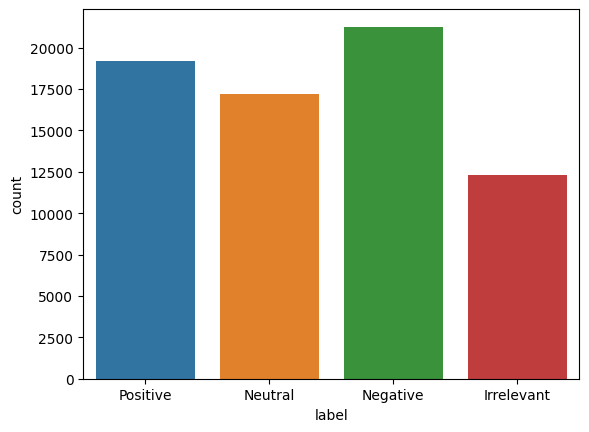

In [ ]:
sns.countplot(x=df['label'])
df['label'].value_counts(normalize=True)

Далее идет предобработка текста и класса

In [ ]:
sp = spacy.load('en_core_web_sm')
nlp = en_core_web_sm.load()

In [ ]:
def preprocess(df):
    """
    Подготовка df
    """
    preproc_df = pd.DataFrame(columns=['text'])
    preproc_df.text = df.text.apply(lambda t: pd.Series(preprocess_text(t)))

    label_encoder = LabelEncoder()
    preproc_df['label'] = label_encoder.fit_transform(df.label)

    return preproc_df

In [ ]:
def preprocess_text(text):
    """
    Подготовка текста
    """
    text = lemmatization_del_sw(text)
    text = simplify_punctuation(text)
    text = re.sub(r'([^a-zA-Z\\n]+)', ' ', text)
    text = re.sub(r'\'s ', ' is ', re.sub(r'\'m ', ' am ', re.sub(r'im ', 'i am ', re.sub(r'n\'t', ' not', re.sub(r' k ', ' okey ', re.sub(r' t ', ' not ', re.sub(r' s ', ' is ', text)))))))
    # из-за специфики сокращения слов прописываем некоторые замены
    text = lemmatization_del_sw(text)
    return text

In [ ]:
def lemmatization_del_sw(text):
    """
    Лемматизация, удаление стоп слов
    """
    doc = sp(text)
    lemmatized_output = ' '.join([str(token.lemma_) for token in doc])
    text_without_stop_words = ' '.join([t.text for t in nlp(lemmatized_output) if not t.is_stop])
    return text_without_stop_words

In [ ]:
def simplify_punctuation(text):
    """
    Удаление лишних пробелов, строк, знаков препинания
    """
    text = re.sub(r'([^a-zA-Z\'\\n]+)', ' ', text)
    text = re.sub(r"^\s+", "", text)
    text = re.sub(r"[ ]*(\n|\r\n|\r)[ ]*", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\s+$", "", text)
    return text.lower()

In [ ]:
data = preprocess(df)

In [ ]:
data # 0 - Irrelevant, 1 - Negative, 2 - Neutral, 3 - Positive

,text,label
0,m borderland murder,3
1,come border kill,3
2,m borderland kill,3
3,m come borderland murder,3
4,m borderland murder,3
...,...,...
69969,suikoden alex kidd miracle world persona soul ...,2
69970,thank match fund home depot rw payment generou...,3
69971,late night stream boy come watch warzone run s...,2
69972,toronto art culture capital canada wonder want...,0


Подготовка текста занимает некоторое время, поэтому стоит сохранить DF и затем уже подгружать его

In [ ]:
data.to_csv('preproc_twitter.csv', index=False)

In [ ]:
labels = {0: 'Irrelevant', 1: 'Negative', 2: 'Neutral', 3: 'Positive'} # Это на будущее

#### **Визуализация**

Построим гистограмму встречаемости слов и облако слов

In [ ]:
data = pd.read_csv('preproc_twitter.csv')
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
text = ' '.join(data['text'])
fdist = FreqDist(text.split())

(-0.5, 399.5, 199.5, -0.5)

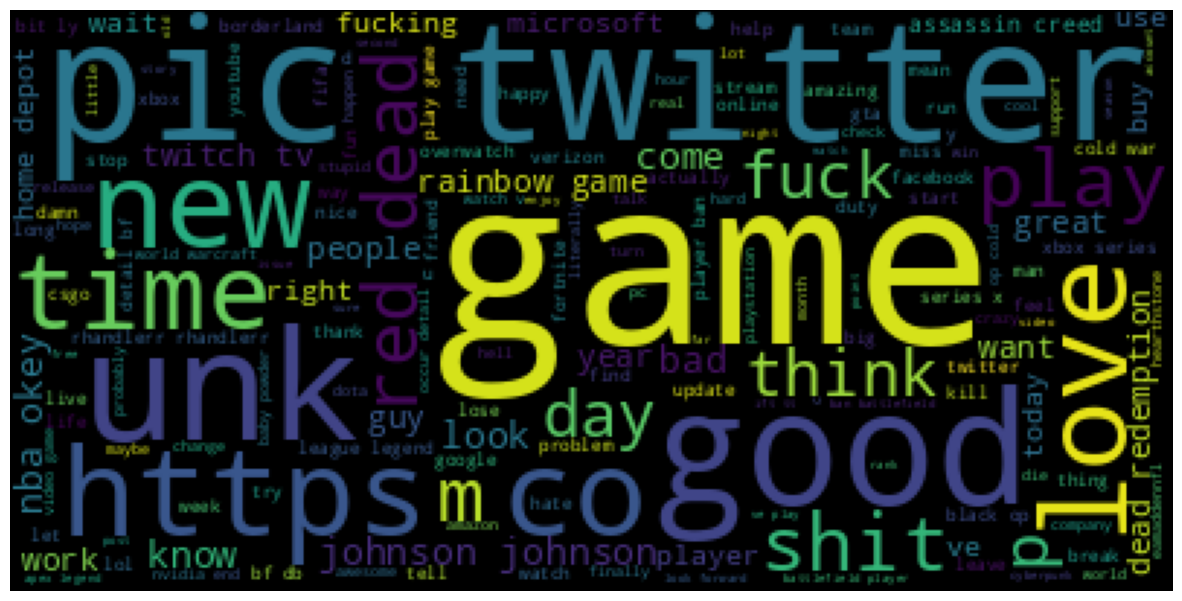

In [ ]:
cloud = WordCloud().generate(text)

plt.figure(figsize=(15,8))
plt.imshow(cloud)
plt.axis('off')

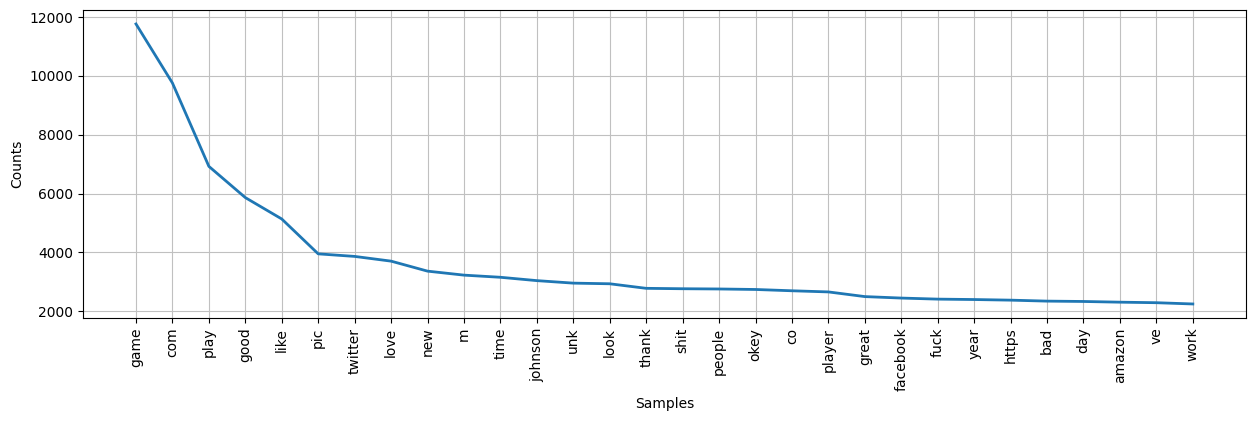

In [ ]:
plt.figure(figsize=(15,4))
fdist.plot(30);

#### **Классификация с помощью классического ML**

In [ ]:
df_vec = pd.read_csv('preproc_twitter.csv')
df_vec.dropna(inplace=True)
df_vec.reset_index(drop=True, inplace=True)

Преобразуем текст в частотные вектора список с помощью TF-IDF

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
tfidf_vectorizer = TfidfVectorizer(min_df=2, sublinear_tf=True, tokenizer=lambda t: tokenizer.tokenize(t))
train = tfidf_vectorizer.fit_transform(df_vec.text)
label = df_vec.label

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Выберем 3 классификатора (брала и другие, но у этих скор был лучше)

In [ ]:
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'RandomForestClassifier': RandomForestClassifier(),
    'LGBMClassifier': LGBMClassifier()}

Выбираем метрики

In [ ]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

Создаем функцию для оценки моделей с помощью кросс валидации

In [ ]:
def evaluate_vectorizer(name, clf):
    scores = cross_validate(clf, train, label, scoring=scoring, cv=5) #.mean()
    print(name)
    for key, value in scores.items():
        print(key + ': %7.5f' % np.mean(value))
    print('-'*30)

In [ ]:
for name, clf in classifiers.items():
    evaluate_vectorizer(name, clf)

LogisticRegression
fit_time: 17.88129
score_time: 0.05402
test_accuracy: 0.44389
test_precision_macro: 0.42693
test_recall_macro: 0.42645
test_f1_macro: 0.42418
------------------------------
RandomForestClassifier
fit_time: 220.48951
score_time: 1.78325
test_accuracy: 0.45113
test_precision_macro: 0.42536
test_recall_macro: 0.42083
test_f1_macro: 0.41256
------------------------------
LGBMClassifier
fit_time: 38.81486
score_time: 0.61791
test_accuracy: 0.44350
test_precision_macro: 0.42464
test_recall_macro: 0.42102
test_f1_macro: 0.41732
------------------------------


#### **Классификация с использованием нейронных сетей**

In [ ]:
df_NN = pd.read_csv('preproc_twitter.csv')
df_NN.dropna(inplace=True)
df_NN.reset_index(drop=True, inplace=True)

Преобразуем текст в числовой список

In [ ]:
top_words = 30000
tokenizer = Tokenizer(num_words=top_words, split=' ')
tokenizer.fit_on_texts(df_NN.text.values)
X_NN = tokenizer.texts_to_sequences(df_NN.text.values)
X_NN = pad_sequences(X_NN)

Разделение датасета на обучающую, валидационную и тренировочную выборку для нейронных сетей

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_NN, df_NN.label, test_size=0.2, random_state=42)

CNN

In [ ]:
embedding_dim = 16
BATCH_SIZE = 64
vocab_size = 30000

In [ ]:
model_cnn = Sequential([
    Embedding(vocab_size+1, embedding_dim),
    Conv1D(16, 3, activation='relu'),
    MaxPooling1D(3),
    Conv1D(16, 3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax')
])


Компилируем модель

In [ ]:
model_cnn.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

Сводка по модели

In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          480016    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          784       
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          784       
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                2

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True)]

history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks
    )

Epoch 1/20
1738/1738 [==============================] - 25s 14ms/step - loss: 1.1702 - accuracy: 0.4738 - val_loss: 0.9327 - val_accuracy: 0.6321
Epoch 2/20
1738/1738 [==============================] - 24s 14ms/step - loss: 0.7262 - accuracy: 0.7278 - val_loss: 0.6731 - val_accuracy: 0.7582
Epoch 3/20
1738/1738 [==============================] - 24s 14ms/step - loss: 0.4904 - accuracy: 0.8309 - val_loss: 0.5773 - val_accuracy: 0.8051
Epoch 4/20
1738/1738 [==============================] - 22s 13ms/step - loss: 0.3722 - accuracy: 0.8739 - val_loss: 0.5375 - val_accuracy: 0.8254
Epoch 5/20
1738/1738 [==============================] - 23s 13ms/step - loss: 0.3009 - accuracy: 0.8982 - val_loss: 0.5307 - val_accuracy: 0.8365
Epoch 6/20
1738/1738 [==============================] - 23s 13ms/step - loss: 0.2528 - accuracy: 0.9157 - val_loss: 0.5432 - val_accuracy: 0.8420
Epoch 7/20
1738/1738 [==============================] - 26s 15ms/step - loss: 0.2159 - accuracy: 0.9274 - val_loss: 0.5627 -

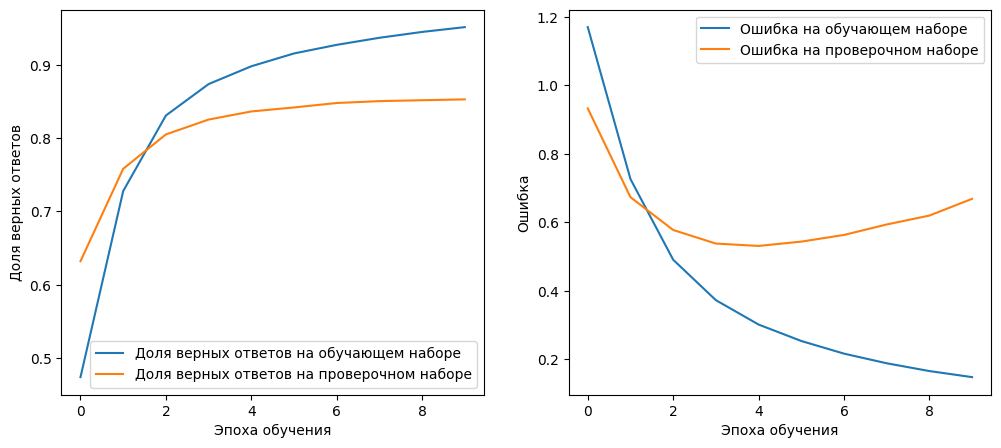

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_cnn.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend();

#### **RNN**

In [ ]:
model_rnn = Sequential([
    Embedding(vocab_size+1, embedding_dim),
    LSTM(64,dropout=0.25,recurrent_dropout=0.25),
    Dense(16,activation='relu'),
    Dense(16,activation='relu'),
    Dense(16,activation='relu')
])

Компилируем модель

In [ ]:
model_rnn.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

Сводка по модели

In [ ]:
model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          480016    
                                                                 
 lstm_1 (LSTM)               (None, 64)                20736     
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
Total params: 502,336
Trainable params: 502,336
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True)]

history_rnn = model_cnn.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks
    )

Epoch 1/20
1738/1738 [==============================] - 36s 20ms/step - loss: 0.2580 - accuracy: 0.9123 - val_loss: 0.5304 - val_accuracy: 0.8438
Epoch 2/20
1738/1738 [==============================] - 31s 18ms/step - loss: 0.2155 - accuracy: 0.9281 - val_loss: 0.5403 - val_accuracy: 0.8457
Epoch 3/20
1738/1738 [==============================] - 24s 14ms/step - loss: 0.1868 - accuracy: 0.9378 - val_loss: 0.5967 - val_accuracy: 0.8458
Epoch 4/20
1738/1738 [==============================] - 27s 16ms/step - loss: 0.1654 - accuracy: 0.9442 - val_loss: 0.6309 - val_accuracy: 0.8533
Epoch 5/20
1738/1738 [==============================] - 24s 14ms/step - loss: 0.1462 - accuracy: 0.9504 - val_loss: 0.6753 - val_accuracy: 0.8554
Epoch 6/20
1738/1738 [==============================] - 24s 14ms/step - loss: 0.1312 - accuracy: 0.9566 - val_loss: 0.7143 - val_accuracy: 0.8574
Epoch 6: early stopping


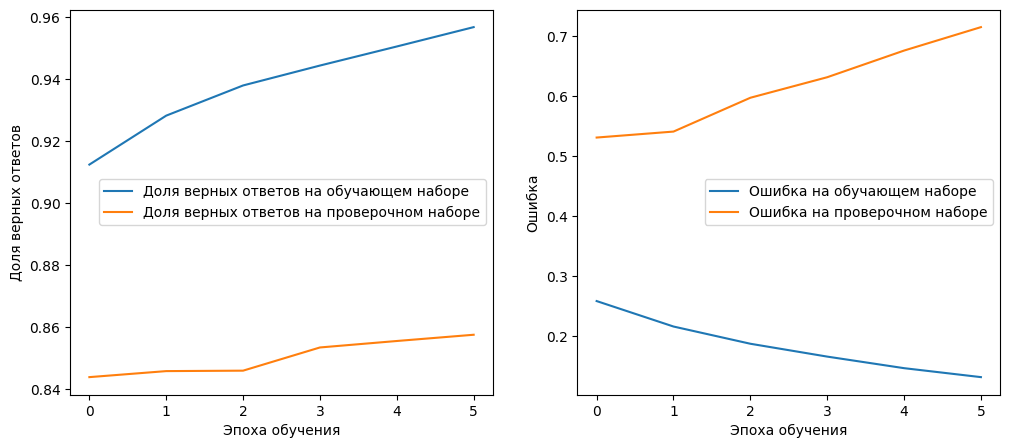

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_rnn.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_rnn.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_rnn.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_rnn.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend();

#### **Сравнение CNN и Random Forest**

Обучим и оценим Random Forest на той же обучающей и тестовой выборке

In [ ]:
RF_Clf = RandomForestClassifier(class_weight='balanced')
RF_Clf.fit(X_train, y_train)
y_pred = RF_Clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.54      0.64      2385
           1       0.63      0.79      0.70      4140
           2       0.71      0.73      0.72      3542
           3       0.75      0.66      0.70      3835

    accuracy                           0.70     13902
   macro avg       0.72      0.68      0.69     13902
weighted avg       0.71      0.70      0.70     13902



Выведем скор по тем же метрикам для CNN

In [ ]:
y_pred = model_cnn.predict(X_val)
y_pred = np.array([np.argmax(i) for i in y_pred])
print(classification_report(y_val, y_pred))

435/435 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      2385
           1       0.87      0.86      0.86      4140
           2       0.91      0.79      0.85      3542
           3       0.77      0.89      0.83      3835

    accuracy                           0.84     13902
   macro avg       0.84      0.83      0.83     13902
weighted avg       0.84      0.84      0.84     13902

